In [15]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import torch
import pandas as pd
import numpy as np

from functools import partial
from typing import Optional

from captum.attr import LayerIntegratedGradients

from transformer_lens.utils import get_act_name, get_device
from transformer_lens import ActivationCache, HookedTransformer, HookedTransformerConfig
from transformer_lens.hook_points import HookPoint

import seaborn as sns
import matplotlib.pyplot as plt
from utils import plot_attn

In [2]:
from enum import Enum
from torch.utils.data import Dataset, DataLoader

class Task(Enum):
    IOI = 1
    GENDER_BIAS = 2
    GREATER_THAN = 3
    CAPITAL_COUNTRY = 4
    SVA = 5
    HYPERNYMY = 6

# Implementation of dataset loader based on https://github.com/hannamw/eap-ig-faithfulness

def collate_EAP(xs, task: Task):
    clean, corrupted, labels = zip(*xs)
    clean = list(clean)
    corrupted = list(corrupted)
    if task != Task.HYPERNYMY:
        labels = torch.tensor(labels)
    return clean, corrupted, labels

class TaskDataset(Dataset):
    def __init__(self, task: Task):
        filename = task.name.lower()
        self.task = task
        self.df = pd.read_csv(f'datasets/{filename}.csv')

    def __len__(self):
        return len(self.df)
    
    def shuffle(self):
        self.df = self.df.sample(frac=1)

    def head(self, n: int):
        self.df = self.df.head(n)
    
    def __getitem__(self, index):
        row = self.df.iloc[index]
        label = None

        if self.task == Task.IOI:
            label = [row['correct_idx'], row['incorrect_idx']]
            return row['clean'], row['corrupted_hard'], label
        
        if self.task == Task.GREATER_THAN:
            label = row['correct_idx']
        elif self.task == Task.HYPERNYMY:
            answer = torch.tensor(eval(row['answers_idx']))
            corrupted_answer = torch.tensor(eval(row['corrupted_answers_idx']))
            label = [answer, corrupted_answer]
        elif self.task == Task.CAPITAL_COUNTRY:
            label = [row['country_idx'], row['corrupted_country_idx']]
        elif self.task == Task.GENDER_BIAS:
            label = [row['clean_answer_idx'], row['corrupted_answer_idx']]
        elif self.task == Task.SVA:
            label = row['plural']
        else:
            raise ValueError(f'Got invalid task: {self.task}')
        
        return row['clean'], row['corrupted'], label
    
    def to_dataloader(self, batch_size: int):
        return DataLoader(self, batch_size=batch_size, collate_fn=partial(collate_EAP, task=self.task))

In [32]:
def logit_diff_metric(logits, metric_labels):
    correct_index = metric_labels[:, 0]
    incorrect_index = metric_labels[:, 1]
    logits_last = logits[:, -1, :]
    batch_size = logits.size(0)
    correct_logits = logits_last[torch.arange(batch_size), correct_index]
    incorrect_logits = logits_last[torch.arange(batch_size), incorrect_index]
    return correct_logits - incorrect_logits

In [3]:
torch.set_grad_enabled(False)

device = get_device()
# device = torch.device("cpu")
model = HookedTransformer.from_pretrained("gpt2-small", device=device)

# Explicitly calculate and expose the result for each attention head
model.set_use_attn_result(True)
model.set_use_hook_mlp_in(True)

Loaded pretrained model gpt2-small into HookedTransformer


# Ablation studies

In [34]:
ioi_dataset = TaskDataset(Task.IOI)
ioi_dataloader = ioi_dataset.to_dataloader(batch_size=10)

clean_input, corrupted_input, labels = next(iter(ioi_dataloader))

clean_tokens = model.to_tokens(clean_input)
corrupted_tokens = model.to_tokens(corrupted_input)

clean_logits, clean_cache = model.run_with_cache(clean_tokens)
clean_logit_diff = logit_diff_metric(clean_logits, labels)
print(f"Clean logit difference: {clean_logit_diff}")

corrupted_logits, corrupted_cache = model.run_with_cache(corrupted_tokens)
corrupted_logit_diff = logit_diff_metric(corrupted_logits, labels)
print(f"Corrupted logit difference: {corrupted_logit_diff}")

Clean logit difference: tensor([-0.0307, -0.9269, -0.4937,  2.2320,  0.6754,  4.0447, -0.1785,  1.1947,
         1.1514,  1.7507], device='cuda:0')
Corrupted logit difference: tensor([-0.0387, -0.9451, -0.5103,  2.2153,  0.6299, -3.2074, -0.1823,  1.1766,
        -3.0072,  1.7392], device='cuda:0')


In [ ]:
ioi_ig_zero_mlp = torch.load("saved_results/ioi_ig_zero_mlp.pt")
ioi_ig_zero_attn = torch.load("saved_results/ioi_ig_zero_attn.pt")

ioi_ig_mlp = torch.load("saved_results/ioi_ig_mlp.pt")
ioi_ig_attn = torch.load("saved_results/ioi_ig_attn.pt")

ioi_ap_mlp = torch.load("saved_results/ioi_ap_mlp.pt")
ioi_ap_attn = torch.load("saved_results/ioi_ap_attn.pt")

ig_mlp, ap_mlp, ig_attn, ap_attn = ioi_ig_mlp[0], ioi_ap_mlp[0], ioi_ig_attn[0], ioi_ap_attn[0]

In [28]:
def mask_insignificant(results):
    # Only keep components which are above a baseline
    mean = torch.mean(results)
    std = torch.std(results)
    return torch.where(results.abs() > mean + std, results, 0.)

In [49]:
def run_ablated_attn(model: HookedTransformer, layer_idx, head_idx, corrupted_cache, metric, metric_labels, *model_args, **model_kwargs):
    # Patch in corrupted activations
    def ablate_head_hook(act, hook):
        act[:, :, head_idx] = corrupted_cache[hook.name][:, :, head_idx]
        return act
    
    layer_name = get_act_name("result", layer_idx)

    logits = model.run_with_hooks(*model_args, **model_kwargs, fwd_hooks=[(layer_name, ablate_head_hook)])
    return metric(logits, metric_labels)

def run_ablated_neuron(model, layer_idx, neuron_idx, corrupted_cache, metric, metric_labels, *model_args, **model_kwargs):
    ablate_head_hook = lambda act, hook: corrupted_cache[hook.name][:, :, neuron_idx]
    layer_name = get_act_name("post", layer_idx)

    logits = model.run_with_hooks(*model_args, **model_kwargs, fwd_hooks=[(layer_name, ablate_head_hook)])
    return metric(logits, metric_labels)

In [67]:
def test_ablated_ioi_performance(layer_idx, pos, is_attn: bool):
    print(f"Test IOI performance with ablated {layer_idx, pos}")
    test_dataset = TaskDataset(Task.IOI)
    test_dataloader = test_dataset.to_dataloader(batch_size=10)

    mean_performance = 0
    for clean_input, corrupted_input, labels in test_dataloader:
        clean_tokens = model.to_tokens(clean_input)
        corrupted_tokens = model.to_tokens(corrupted_input)
        _, corrupted_cache = model.run_with_cache(corrupted_tokens)
        
        if is_attn:
            performance = run_ablated_attn(model, layer_idx, pos, corrupted_cache, logit_diff_metric, labels, clean_tokens)
        else:
            performance = run_ablated_neuron(model, layer_idx, pos, corrupted_cache, logit_diff_metric, labels, clean_tokens)
        
        mean_performance += performance.sum()

    mean_performance /= len(test_dataset)
    print(f"Mean performance: {mean_performance}")
    return mean_performance

In [60]:
# Baseline performance
test_dataset = TaskDataset(Task.IOI)
test_dataloader = test_dataset.to_dataloader(batch_size=10)

baseline_performance = 0

for clean_input, corrupted_input, labels in test_dataloader:
    clean_tokens = model.to_tokens(clean_input)
    clean_logits, clean_cache = model.run_with_cache(clean_tokens)
    baseline_performance += logit_diff_metric(clean_logits, labels).sum(dim=-1)

baseline_performance /= len(test_dataset)
print(f"Baseline performance: {baseline_performance}")

Baseline performance: 0.6607611179351807


In [ ]:
ap_attn_sig = torch.nonzero(mask_insignificant(ap_attn)) # Shape [n_indices, 2]

ap_attn_performances = []
for layer_idx, head_idx in ap_attn_sig:
    mean_performance = test_ablated_ioi_performance(layer_idx, head_idx, is_attn=True)
    ap_attn_performances.append(mean_performance)

# The greater the performance value, the better
print(ap_attn_performances)

Test IOI performance with ablated (tensor(0), tensor(6))
Mean performance: 0.6678401231765747
Test IOI performance with ablated (tensor(0), tensor(8))
Mean performance: 0.6605553030967712
Test IOI performance with ablated (tensor(1), tensor(9))
Mean performance: 0.6594219207763672
Test IOI performance with ablated (tensor(3), tensor(4))
Mean performance: 0.625079870223999
Test IOI performance with ablated (tensor(4), tensor(10))
Mean performance: 0.6582724452018738
Test IOI performance with ablated (tensor(5), tensor(11))
Mean performance: 0.653248131275177
Test IOI performance with ablated (tensor(8), tensor(6))
Mean performance: 0.3205397129058838
Test IOI performance with ablated (tensor(8), tensor(10))
Mean performance: 0.26987776160240173
Test IOI performance with ablated (tensor(9), tensor(5))
Mean performance: 0.6275280117988586
Test IOI performance with ablated (tensor(9), tensor(9))
Mean performance: 0.4603160321712494
Test IOI performance with ablated (tensor(10), tensor(2))


{(0, 6): 0.007079005241394043, (0, 8): -0.00020581483840942383, (1, 9): -0.0013391971588134766, (3, 4): -0.03568124771118164, (4, 10): -0.0024886727333068848, (5, 11): -0.007512986660003662, (8, 6): -0.3402214050292969, (8, 10): -0.39088335633277893, (9, 5): -0.03323310613632202, (9, 9): -0.20044508576393127, (10, 2): -0.03941082954406738, (10, 7): 0.5841758251190186, (10, 10): -0.07491087913513184, (11, 0): -0.00470578670501709, (11, 2): 0.1482480764389038, (11, 3): -0.02527308464050293, (11, 6): 0.018336772918701172, (11, 8): -0.018752872943878174}


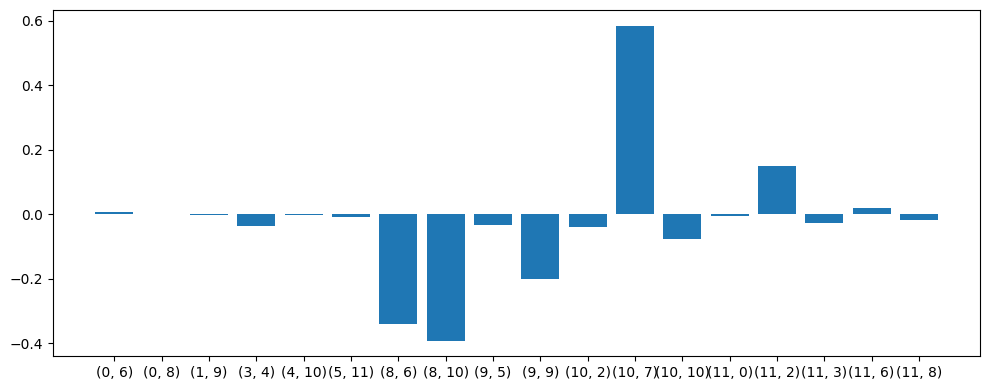

In [ ]:
ap_attn_performance_diff = {}

for (layer, head), score in zip(ap_attn_sig, performances):
    ap_attn_performance_diff[(layer.item(), head.item())] = (score - baseline_performance).item()

print(ap_attn_performance_diff)

plt.figure(figsize=(10,4))
plt.bar([str(k) for k in ap_attn_performance_diff.keys()], ap_attn_performance_diff.values())
plt.tight_layout()
plt.show()

In [79]:
ig_attn_sig = torch.nonzero(mask_insignificant(ig_attn)) # Shape [n_indices, 2]

ig_attn_performances = []
for layer_idx, head_idx in ig_attn_sig:
    mean_performance = test_ablated_ioi_performance(layer_idx, head_idx, is_attn=True)
    ig_attn_performances.append(mean_performance)

Test IOI performance with ablated (tensor(0), tensor(4))
Mean performance: 0.6606829762458801
Test IOI performance with ablated (tensor(0), tensor(6))
Mean performance: 0.6678401231765747
Test IOI performance with ablated (tensor(1), tensor(9))
Mean performance: 0.6594219207763672
Test IOI performance with ablated (tensor(3), tensor(4))
Mean performance: 0.625079870223999
Test IOI performance with ablated (tensor(4), tensor(10))
Mean performance: 0.6582724452018738
Test IOI performance with ablated (tensor(5), tensor(11))
Mean performance: 0.653248131275177
Test IOI performance with ablated (tensor(8), tensor(6))
Mean performance: 0.3205397129058838
Test IOI performance with ablated (tensor(8), tensor(10))
Mean performance: 0.26987776160240173
Test IOI performance with ablated (tensor(9), tensor(5))
Mean performance: 0.6275280117988586
Test IOI performance with ablated (tensor(9), tensor(9))
Mean performance: 0.4603160321712494
Test IOI performance with ablated (tensor(10), tensor(2))


{(0, 4): 0.007079005241394043, (0, 6): -0.00020581483840942383, (1, 9): -0.0013391971588134766, (3, 4): -0.03568124771118164, (4, 10): -0.0024886727333068848, (5, 11): -0.007512986660003662, (8, 6): -0.3402214050292969, (8, 10): -0.39088335633277893, (9, 5): -0.03323310613632202, (9, 9): -0.20044508576393127, (10, 2): -0.03941082954406738, (10, 7): 0.5841758251190186, (10, 10): -0.07491087913513184, (11, 0): -0.00470578670501709, (11, 2): 0.1482480764389038, (11, 3): -0.02527308464050293, (11, 6): 0.018336772918701172, (11, 8): -0.018752872943878174}


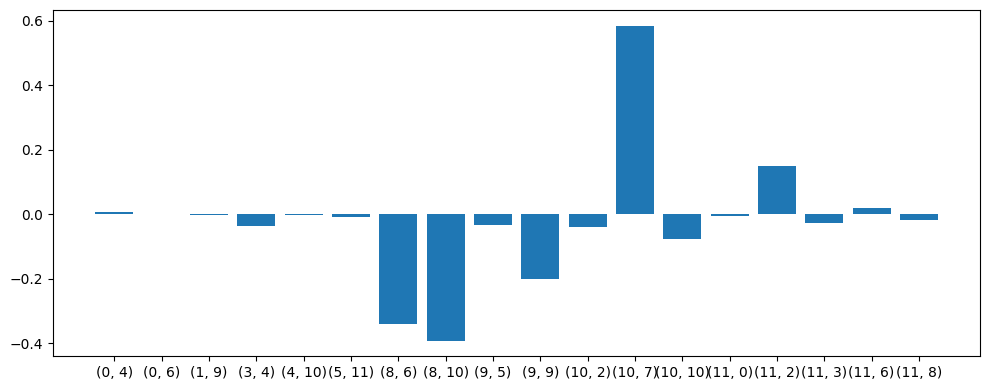

In [80]:
ig_attn_performance_diff = {}

for (layer, head), score in zip(ig_attn_sig, performances):
    ig_attn_performance_diff[(layer.item(), head.item())] = (score - baseline_performance).item()

print(ig_attn_performance_diff)

plt.figure(figsize=(10,4))
plt.bar([str(k) for k in ig_attn_performance_diff.keys()], ig_attn_performance_diff.values())
plt.tight_layout()
plt.show()